# Ideas to forward fill

In This notebook we investigate how to do TDD calculation using forward filling. In particular, we discuss the problem of forward filling in cases where we have missing data and can't make a good judgement of which value to use to fill.

**Note**: Sometimes we might now know if it is missing or the last data point is still valid.

In [2]:
#append partent directory to path
import sys
sys.path.append('..')
from studies.studydataset import StudyDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Let's start by creating a small test-dataset.

13


,datetime,basal,date
0,2024-06-20 01:00:00,1,2024-06-20
1,2024-06-20 07:00:00,2,2024-06-20
2,2024-06-20 13:00:00,1,2024-06-20
3,2024-06-20 19:00:00,2,2024-06-20
8,2024-06-22 01:00:00,1,2024-06-22
9,2024-06-22 07:00:00,2,2024-06-22
10,2024-06-22 13:00:00,1,2024-06-22
11,2024-06-22 19:00:00,2,2024-06-22
12,2024-06-23 01:00:00,1,2024-06-23


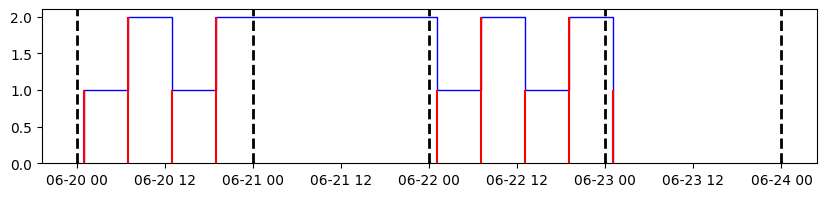

In [3]:
days = 3
basalDuration=6

#generate a pandas dataframe with datetime column with values over two days with random gaps of random hours between them
datetimes = datetime(2024,6,20,1,0,0) + pd.to_timedelta(np.arange(0,days*24+basalDuration,basalDuration), unit='h')
datetimes = sorted(datetimes)
datetimes
print(len(datetimes))

#rotate basals using these values 0.25,0.5,1, 1.25
basals = [1,2]
basals = [basals[i%len(basals)] for i in range(0,len(datetimes))]

df = pd.DataFrame({'datetime':datetimes, 'basal':basals})
#drop the 4th to 8th value
df = df.drop(df.index[4:8])

#get the dates for which there is data
start_date = df.datetime.min().date()
end_date = df.datetime.max().date()

dates = pd.date_range(start_date, end_date+pd.Timedelta(days=1), freq='D')

plt.figure(figsize=(10,2))
plt.stem(df['datetime'],df['basal'],basefmt=' ',markerfmt=' ',linefmt='r-')
plt.stairs(df['basal'].values[:-1], df['datetime'],color='blue')

#draw vertical lines for each date 
for date in dates:
    plt.axvline(date, color='black', linestyle='--', lw=2)

df['date'] = df.datetime.dt.date
display(df)

Create midnight support points for calculating TDD from midnight to midnight

In [4]:
#create midnight support points
supports = dates
combined_df = pd.concat([df, pd.DataFrame({'datetime': supports})]).sort_values(by='datetime').reset_index(drop=True)
display(combined_df)

,datetime,basal,date
0,2024-06-20 00:00:00,NaN,NaN
1,2024-06-20 01:00:00,1.0,2024-06-20
2,2024-06-20 07:00:00,2.0,2024-06-20
3,2024-06-20 13:00:00,1.0,2024-06-20
4,2024-06-20 19:00:00,2.0,2024-06-20
5,2024-06-21 00:00:00,NaN,NaN
6,2024-06-22 00:00:00,NaN,NaN
7,2024-06-22 01:00:00,1.0,2024-06-22
8,2024-06-22 07:00:00,2.0,2024-06-22
9,2024-06-22 13:00:00,1.0,2024-06-22


Combine and forward fill values

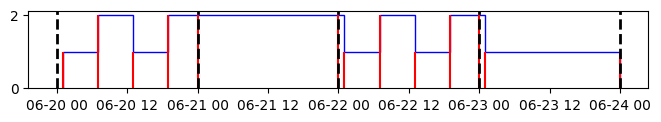

In [5]:
# Combine and forward-fill 
combined_df = pd.concat([df, pd.DataFrame({'datetime': supports})]).sort_values(by='datetime').reset_index(drop=True)
combined_df['basal'] = combined_df.basal.ffill()
combined_df['date'] = combined_df.datetime.dt.date

#draw
plt.figure(figsize=(8,1))
plt.stem(combined_df['datetime'],combined_df['basal'],basefmt=' ',markerfmt=' ',linefmt='r-')
plt.stairs(combined_df['basal'].values[:-1], combined_df['datetime'],color='blue')
for date in dates:
    plt.axvline(date, color='black', linestyle='--', lw=2)

We now see that this method would assume the previous basal rate, even if there are no datapoints for a whole day. We don't want to do this because it is unlikely that there are no basal rates reported. Instead, basal rates were probably disabled. 

Instead, we only want to forward fill if the previous basal rate is within 2 hours.

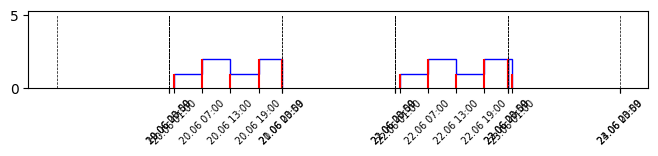

In [6]:

def durations_since_previous_valid_value(dates, values):
    """
    Calculate the durations between each date and the previous date with a valid value (non NaN).

    Parameters:
    dates (list): A list of dates.
    values (list): A list of values.

    Returns:
    list: A list of durations between each date and the previous valid date. NaN if there is no previous valid date.
    """
    last_valid_date = None
    durations = []
    for (date, value) in zip(dates, values):
        duration = np.NaN
        if last_valid_date is not None:
            duration = date - last_valid_date
        if not np.isnan(value):
            last_valid_date = date
        durations.append(duration)
    return durations

def combine_and_forward_fill(datetimes, basals, gap=float('inf')):
    df = pd.DataFrame({'datetime':datetimes, 'basal':basals})
    #add support points around midnight
    start_date = df.datetime.min().date()
    end_date = df.datetime.max().date()
    dates = pd.date_range(start_date, end_date+pd.Timedelta(days=1), freq='D')
    supports = (dates-timedelta(microseconds=1)).append(dates+timedelta(microseconds=1))
    combined_df = pd.concat([df, pd.DataFrame({'datetime': supports})]).sort_values(by='datetime').reset_index(drop=True)
    
    #forward fill, but only if duration between basal values is smaller than the threshold
    durations = durations_since_previous_valid_value(combined_df['datetime'], combined_df['basal'])    
    bSignificantGap = [True if pd.notna(duration) and duration >= gap else False for duration in np.array(durations)]
    combined_df['basal'] = combined_df['basal'].where(bSignificantGap, combined_df['basal'].ffill())
    return combined_df

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_basal_rates(datetimes, basals, by_date=True):
    df= pd.DataFrame({'datetime':datetimes, 'basal': basals})
    df['date'] = df.datetime.dt.date

    plt.figure(figsize=(8,1))
    if by_date:
        for date, dateFrame in df.dropna(subset=['basal']).groupby('date'):
            plt.stem(dateFrame['datetime'], dateFrame['basal'], basefmt=' ', markerfmt=' ', linefmt='r-')
            plt.stairs(dateFrame['basal'].values[:-1], dateFrame['datetime'], color='blue')
    else:
        plt.stem(df['datetime'], df['basal'], basefmt=' ', markerfmt=' ', linefmt='r-')
        plt.stairs(df['basal'].values[:-1], df['datetime'], color='blue')
    
    plt.vlines(df['date'].values, 0,5, color='black', linestyle='--', lw=0.5)

    # Format x-axis tick labels
    date_fmt = mdates.DateFormatter('%d.%m %H:%M')
    plt.gca().xaxis.set_major_formatter(date_fmt)
    plt.xticks(rotation=45, fontsize='x-small')
    plt.xticks(df.datetime)

combined = combine_and_forward_fill(df.datetime, df.basal, gap=timedelta(hours=8))
combined
plot_basal_rates(combined.datetime, combined.basal)


In [7]:
def integrate_basal(group):
    return np.trapz(group['basal'], (group.datetime-group.datetime.min()).dt.total_seconds()/3600)

#df['hour_since_start'] = df.groupby(df['datetime'].dt.date).datetime.apply(lambda x: x-x.min()).dt.total_seconds()/3600
groups = df.groupby(df['datetime'].dt.date)
integrals = groups.apply(integrate_basal)
integrals

datetime
2024-06-20    27.0
2024-06-22    27.0
2024-06-23     0.0
dtype: float64